In [61]:
import cv2
import os
import numpy as np
import tensorflow as tf
keras = tf.keras
models = tf.keras.models
applications = tf.keras.applications
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import matplotlib.pyplot as plt

In [40]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

MAX_SEQ_LENGTH = 25
NUM_FEATURES = 2048

In [41]:
folder_path = '/Users/saif/Desktop/vm_server/fyp_data'
files = os.listdir(folder_path)
video_files = []
for f in files:
    if '.mp4' in f:
        video_files.append(f)
dataset = {'video_names': video_files, 'labels':[]}
for v in video_files:
    if '_nv' in v:
        dataset['labels'].append('nv')
    elif '_v' in v:
        dataset['labels'].append('v')

dataset = pd.DataFrame(dataset)
dataset.head(10)

,video_names,labels
0,31080872_nv.mp4,nv
1,f08696669_nv.mp4,nv
2,06118078_nv.mp4,nv
3,f98560186_nv.mp4,nv
4,18938233_v.mp4,v
5,30959717_nv.mp4,nv
6,f83411458_nv.mp4,nv
7,95768401_v.mp4,v
8,13846948_nv.mp4,nv
9,f53451125_nv.mp4,nv


In [42]:
train, test = train_test_split(dataset, test_size=0.1, random_state=42)
print(f"Total videos for training: {len(train)}")
print(f"Total videos for testing: {len(test)}")

Total videos for training: 3037
Total videos for testing: 338


In [43]:
class_counts = train['labels'].value_counts()
print(class_counts)

labels
v     1594
nv    1443
Name: count, dtype: int64


In [44]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [45]:
def build_feature_extractor():
    feature_extractor = applications.ResNet50V2(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = applications.resnet_v2.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [46]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train["labels"])
)
print(label_processor.get_vocabulary())

['nv', 'v']


In [47]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    count = 0
    video_paths = df["video_names"].values.tolist()
    labels = df["labels"].values
    labels = np.array(label_processor(labels[..., None]))

    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            frame_indices = np.arange(0, video_length, (video_length // MAX_SEQ_LENGTH)+1)

            for j, frame_index in enumerate(frame_indices):
                if frame_index < video_length:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, int(frame_index), :], verbose=0,
                    )
                else:
                    break
        frame_features[idx,] = temp_frame_features.squeeze()
        val = round((count/num_samples)*100, 2)
        print(f'\rcompleted = {val}%', end='', flush=True)
        count += 1

    return frame_features, labels


train_data, train_labels = prepare_all_videos(train, folder_path)
test_data, test_labels = prepare_all_videos(test, folder_path)

completed = 99.7%%

In [57]:
def get_deep_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    # Define the input layer.
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))

    # First GRU layer with increased number of units and return sequences.
    x = keras.layers.GRU(128, return_sequences=True)(frame_features_input)
    x = keras.layers.BatchNormalization()(x)  # Add batch normalization for stable training

    # Second GRU layer with a smaller number of units.
    x = keras.layers.GRU(128, return_sequences=True)(x)
    x = keras.layers.BatchNormalization()(x)

    # Third GRU layer with even fewer units.
    x = keras.layers.GRU(64)(x)
    x = keras.layers.Dropout(0.5)(x)  # Increase dropout rate to avoid overfitting

    # Add a dense layer with ReLU activation and batch normalization.
    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)

    # Add the output layer with softmax activation.
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    # Create the Keras model.
    rnn_model = keras.Model(frame_features_input, output)

    # Compile the model with appropriate loss, optimizer, and metrics.
    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

    return rnn_model

In [62]:
def run_experiment():
    filepath = "kpt2.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_deep_sequence_model()
    history = seq_model.fit(
        train_data,
        train_labels,
        validation_split=0.2,
        epochs=EPOCHS,
        batch_size=32,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    test_loss, accuracy = seq_model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    # Predict on test data
    predictions = seq_model.predict(test_data)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_labels.flatten()

    # Print the distribution of true and predicted labels
    print("True labels distribution:", Counter(true_classes))
    print("Predicted labels distribution:", Counter(predicted_classes))

    # Calculate and print F1 score, precision, and recall using sklearn
    report = classification_report(true_classes, predicted_classes, target_names=class_names, digits=2, zero_division=0)
    print("Classification Report:\n", report)

    # Calculate and display the confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Save the entire model as an .h5 file
    model_save_path = "final_model.h5"
    seq_model.save(model_save_path)
    print(f"Model saved to {model_save_path}")

    return history, seq_model

class_names = ["nv", "v"]  # Replace with actual class names

Epoch 1/20
76/76 [==============================] - ETA: 0s - loss: 0.5808 - accuracy: 0.7118
Epoch 1: val_loss improved from inf to 0.57594, saving model to kpt2.weights.h5
76/76 [==============================] - 6s 35ms/step - loss: 0.5808 - accuracy: 0.7118 - val_loss: 0.5759 - val_accuracy: 0.6957
Epoch 2/20
76/76 [==============================] - ETA: 0s - loss: 0.3596 - accuracy: 0.8460
Epoch 2: val_loss improved from 0.57594 to 0.46725, saving model to kpt2.weights.h5
76/76 [==============================] - 2s 23ms/step - loss: 0.3596 - accuracy: 0.8460 - val_loss: 0.4672 - val_accuracy: 0.7829
Epoch 3/20
76/76 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.9012
Epoch 3: val_loss did not improve from 0.46725
76/76 [==============================] - 2s 22ms/step - loss: 0.2495 - accuracy: 0.9012 - val_loss: 0.8594 - val_accuracy: 0.7155
Epoch 4/20
76/76 [==============================] - ETA: 0s - loss: 0.1821 - accuracy: 0.9333
Epoch 4: val_loss impro

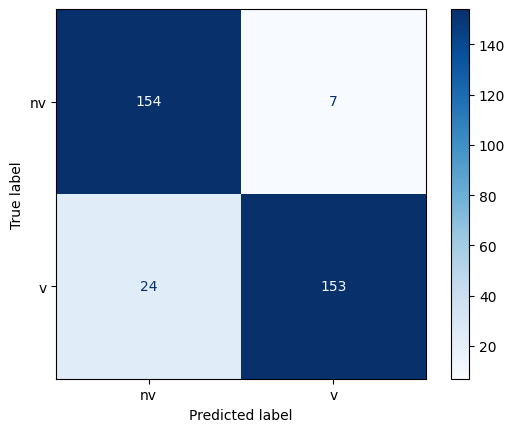

Model saved to final_model.h5


In [63]:
_, sequence_model = run_experiment()